### Load the dataset

In [1]:
!pip install -q -U einops datasets matplotlib tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00


In [53]:
from torch import nn
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import ToTensor
import numpy as np 

In [54]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        kernel_size = 3
        stride = 1
        padding = 1

        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x.unsqueeze(0))
    
downsample_example_model = transforms.Compose([
    DownBlock(1,4)
])

In [55]:
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        kernel_size = 3
        stride = 1
        padding = 1
        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

upsample_example_model = transforms.Compose([
    UpBlock(4,1)
])
    

In [107]:
class UpBlockWithCopy(nn.Module):
    def __init__(self, in_ch, out_ch):
        kernel_size = 3
        stride = 1
        padding = 1
        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        layers = [
            nn.ConvTranspose2d(2*in_ch, out_ch, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((skip, x), 1)
        print ("UpBlockWithCopy --> ", x.shape, skip.shape)
        return self.model(x)

upsample_with_copy_example_model = transforms.Compose([
    UpBlockWithCopy(4,1)
])

Down sample dimensions =  (4, 14, 14)
Down sample dimensions =  (1, 28, 28)
UpBlockWithCopy -->  torch.Size([1, 4, 14, 14]) torch.Size([1, 4, 14, 14])
Down sample dimensions =  (1, 28, 28)


(torch.Size([1, 1, 28, 28]),
 torch.Size([1, 4, 14, 14]),
 torch.Size([1, 1, 28, 28]))

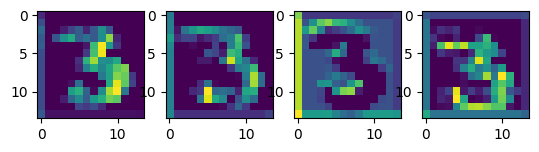

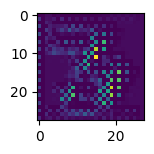

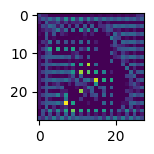

In [105]:
import torch
import torchvision
from torchvision.transforms import Resize, Compose, ToTensor, Lambda, ToPILImage

import math
from inspect import isfunction
from functools import partial
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

def convertTensorToImage(img):
    reverse_transform = Compose([
        Lambda(lambda x: (x*2)+1),
        Lambda(lambda x: x*255),
        ToPILImage()
    ])

    return reverse_transform(img)

def load_dataset_with_transform(image_size):
    data_transforms = Compose([
        Resize((image_size, image_size)),
        ToTensor(),
        Lambda(lambda x: (x*2)-1)
    ])

    dataset = torchvision.datasets.MNIST('./data/', transform=data_transforms, download=True)
    return dataset

data = load_dataset_with_transform(28)

image, label = data[12]

def visualize_conv_2d(sample):
    sample = sample.squeeze(0).detach().numpy()
    plt.figure(figsize=(8,8))

    print("Down sample dimensions = ", sample.shape,)
    for c in range(len(sample)):
        cols =4
        rows = len(sample) // cols
        plt.subplot(rows+1,cols+1, c+1)
        plt.imshow(sample[c])

downsample = downsample_example_model(image)
visualize_conv_2d(downsample)
convertTensorToImage(image)

upsample = upsample_example_model(downsample)
visualize_conv_2d(upsample)
upsample_with_copy = UpBlockWithCopy(4,1)(downsample, downsample)

visualize_conv_2d(upsample_with_copy, )
upsample.shape, downsample.shape, upsample_with_copy.shape

In [109]:
class UNetModel(nn.Module):
    def __init__(self, debug=False) -> None:
        super().__init__()
        down_sampling = [16, 32, 64]
        up_sampling = [64, 32, 16]
        self.debug = debug
        n_input_channels = 1
        latent_image_size = 7
        
        self.init_block = nn.Sequential(
            nn.Conv2d(n_input_channels, down_sampling[0], 3, padding=1),
            nn.BatchNorm2d(down_sampling[0]),
            nn.ReLU()
        )        

        self.down1 = DownBlock(down_sampling[0], down_sampling[1])
        self.down2 = DownBlock(down_sampling[1], down_sampling[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_sampling[2]*latent_image_size**2, down_sampling[1]),
            nn.ReLU(),
            nn.Linear(down_sampling[1], down_sampling[1]),
            nn.ReLU(),
            nn.Linear(down_sampling[1], down_sampling[2]*latent_image_size**2),
            nn.ReLU()
        )
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_sampling[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_sampling[0], up_sampling[0], 3, padding=1),
            nn.BatchNorm2d(up_sampling[0]),
            nn.ReLU(),
        )

        self.up1 = UpBlockWithCopy(up_sampling[0], up_sampling[1])
        self.up2 = UpBlockWithCopy(up_sampling[1], up_sampling[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_sampling[-1], up_sampling[-1], 3, 1, 1),
            nn.BatchNorm2d(up_sampling[-1]),
            nn.ReLU(),
            nn.Conv2d(up_sampling[-1], 3, 3, 1, 1),
        )

    def forward(self, x):
        x = self.init_block(x)
        if self.debug:
            print ('Initialize the model with conversion of image to convolution. ', x.shape)
            visualize_conv_2d(x)

        down1 = self.down1(x.squeeze(0))        
        if self.debug:
            visualize_conv_2d(down1)
        
        down2 = self.down2(down1.squeeze(0))        
        if self.debug:
            visualize_conv_2d(down2)
        
        x = self.to_vec(down2)
        
        if self.debug:
            print (x.shape)
        x = self.dense_emb(x)
        
        if self.debug:
            print (x.shape)
        x = self.up0(x)
        
        if self.debug:
            visualize_conv_2d(x)
        up1 = self.up1(x, down2)
        if self.debug:
            visualize_conv_2d(up1)
        up2 = self.up2(up1, down1)
        if self.debug:
            visualize_conv_2d(up2)
        out = self.out(up2)
        if self.debug:
            visualize_conv_2d(out)

        return out

image, label = data[12]
model = UNetModel(debug=False)

init_block = model(image.unsqueeze(0))
print("Num params: ", sum(p.numel() for p in model.parameters()))


UpBlockWithCopy -->  torch.Size([1, 128, 7, 7]) torch.Size([1, 64, 7, 7])
UpBlockWithCopy -->  torch.Size([1, 64, 14, 14]) torch.Size([1, 32, 14, 14])
Num params:  372547
